<a href="https://colab.research.google.com/github/souzamichel/ml_trading_test_code/blob/main/ml_trading_backtest_code_van_tharpe.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:


# 0) Instalar dependências (execute se necessário)
!pip install --quiet yfinance optuna joblib scikit-learn matplotlib

In [11]:
# 1) Imports
import pandas as pd
import numpy as np
import yfinance as yf
import optuna
from sklearn.model_selection import TimeSeriesSplit
from itertools import product
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

In [12]:
# 2) Download de dados
symbol = "AAPL"
data = yf.download(symbol, period="7y", interval="1d", progress=False)
#data.dropna(subset=["Close"], inplace=True)

/tmp/ipython-input-12-2445785781.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol, period="7y", interval="1d", progress=False)


In [13]:

# 3) Estratégia: breakout canal + trailing stop
def simulate_channel(df: pd.DataFrame, breakout: int, trailing: int) -> pd.Series:
    close = df["Close"].to_numpy()
    pnl = np.zeros(len(close), dtype=float)
    pos = 1; entry = 0.0; trail = 0.0

    for i in range(len(close)):
        price = close[i]
        if i < breakout:
            continue

        window = close[i-breakout:i]
        high_ch, low_ch = window.max(), window.min()

        lo = max(0, i-trailing+1)
        trw = close[lo:i+1]
        trail_high, trail_low = trw.max(), trw.min()

        ret = 0.0
        if pos == 0:
            if price > high_ch:
                pos, entry, trail = 1, price, trail_low
            elif price < low_ch:
                pos, entry, trail = -1, price, trail_high

        elif pos == 1:
            trail = max(trail, trail_low)
            if price < trail:
                ret, pos = price - entry, 0

        else:  # pos == -1
            trail = min(trail, trail_high)
            if price > trail:
                ret, pos = entry - price, 0

        pnl[i] = ret

    return pd.Series(pnl, index=df.index)

In [14]:

# 4) Métricas: Net Profit e Recovery Factor
def performance(pnl: pd.Series):
    net = pnl.sum()
    eq = pnl.cumsum()
    dd = eq - eq.cummax()
    max_dd = dd.min()  # <= 0
    rf = net / abs(max_dd) if max_dd < 0 else np.nan
    return net, rf

In [15]:
# 5) Otimização global multi-objetivo (5-fold CV)
def objective_mo(trial):
    bp = trial.suggest_int("breakout", 5, 60)
    tp = trial.suggest_int("trailing", 1, bp)

    tss = TimeSeriesSplit(n_splits=5)
    nets, rfs = [], []

    for _, te_idx in tss.split(data):
        pnl = simulate_channel(data.iloc[te_idx], bp, tp)
        net, rf = performance(pnl)
        nets.append(net)
        rfs.append(rf if not np.isnan(rf) else -1e6)

    return float(np.mean(nets)), float(np.mean(rfs))

study = optuna.create_study(
    directions=["maximize", "maximize"],
    study_name="global_profit_vs_rf"
)
study.optimize(objective_mo, n_trials=50, n_jobs=1)

[I 2025-07-28 00:06:59,570] A new study created in memory with name: global_profit_vs_rf
/tmp/ipython-input-13-3829972336.py:36: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pnl[i] = ret
[I 2025-07-28 00:06:59,605] Trial 0 finished with values: [148.02906494140626, 10.145190902944355] and parameters: {'breakout': 19, 'trailing': 2}.
[I 2025-07-28 00:06:59,634] Trial 1 finished with values: [141.3168502807617, -199992.18861831824] and parameters: {'breakout': 55, 'trailing': 35}.
[I 2025-07-28 00:06:59,664] Trial 2 finished with values: [141.52804870605468, -199984.8573691411] and parameters: {'breakout': 32, 'trailing': 28}.
[I 2025-07-28 00:06:59,704] Trial 3 finished with values: [139.62008666992188, -199984.5717391027] and parameters: {'breakout': 30, 'trailing': 26}.
[I 2025-07-28 00:06:59,761] Trial 4 fini

In [16]:

# 6) Melhor configuração global (primeiro da Pareto front)
best_global = study.best_trials[0]
best_bp = best_global.params["breakout"]
best_tp = best_global.params["trailing"]

print("=== Best Global Pareto Trial #1 ===")
print(f"Avg Net Profit: {best_global.values[0]:.2f}")
print(f"Avg Recovery  : {best_global.values[1]:.2f}")
print(f"Params        : breakout={best_bp}, trailing={best_tp}")

=== Best Global Pareto Trial #1 ===
Avg Net Profit: 151.13
Avg Recovery  : 25.15
Params        : breakout=44, trailing=29


In [17]:

# 7) Walk-forward real: IS re-otimização em cada janela
out_months = [3, 4, 5, 6]
in_mults   = [2, 3, 4]
results = []

start = data.index.min()
end   = data.index.max()

for om, im in product(out_months, in_mults):
    train_len = pd.DateOffset(months=om * im)
    test_len  = pd.DateOffset(months=om)
    window_start = start

    while True:
        train_end = window_start + train_len
        test_end  = train_end + test_len
        if test_end > end:
            break

        df_train = data[(data.index >= window_start) & (data.index < train_end)]
        df_test  = data[(data.index >= train_end)     & (data.index < test_end)]
        if len(df_test) < 2:
            break

        # re-otimiza em IS
        def obj_wf(trial):
            bp2 = trial.suggest_int("breakout", 20, 400)
            tp2 = trial.suggest_int("trailing", 2, bp2)
            pnl_is = simulate_channel(df_train, bp2, tp2)
            net_is, rf_is = performance(pnl_is)
            rf_obj = rf_is if not np.isnan(rf_is) else -1e6
            return float(net_is), float(rf_obj)

        study_wf = optuna.create_study(directions=["maximize","maximize"])
        study_wf.optimize(obj_wf, n_trials=20, timeout=60)

        bp2 = study_wf.best_trials[0].params["breakout"]
        tp2 = study_wf.best_trials[0].params["trailing"]
        pnl_oos = simulate_channel(df_test, bp2, tp2)
        net_oos, rf_oos = performance(pnl_oos)

        results.append({
            "out_months":   om,
            "in_mult":      im,
            "train_start":  window_start,
            "train_end":    train_end,
            "test_end":     test_end,
            "breakout_is":  bp2,
            "trailing_is":  tp2,
            "net_oos":      net_oos,
            "rf_oos":       rf_oos
        })

        window_start = test_end

res_df = pd.DataFrame(results)

[I 2025-07-28 00:07:01,991] A new study created in memory with name: no-name-5b333d69-0995-418c-9b76-44e04110edfe
[I 2025-07-28 00:07:01,999] Trial 0 finished with values: [0.0, -1000000.0] and parameters: {'breakout': 221, 'trailing': 10}.
[I 2025-07-28 00:07:02,006] Trial 1 finished with values: [0.0, -1000000.0] and parameters: {'breakout': 266, 'trailing': 117}.
[I 2025-07-28 00:07:02,011] Trial 2 finished with values: [0.0, -1000000.0] and parameters: {'breakout': 312, 'trailing': 213}.
[I 2025-07-28 00:07:02,016] Trial 3 finished with values: [0.0, -1000000.0] and parameters: {'breakout': 245, 'trailing': 189}.
[I 2025-07-28 00:07:02,021] Trial 4 finished with values: [0.0, -1000000.0] and parameters: {'breakout': 168, 'trailing': 91}.
[I 2025-07-28 00:07:02,027] Trial 5 finished with values: [0.0, -1000000.0] and parameters: {'breakout': 298, 'trailing': 144}.
[I 2025-07-28 00:07:02,041] Trial 6 finished with values: [0.0, -1000000.0] and parameters: {'breakout': 334, 'trailing'

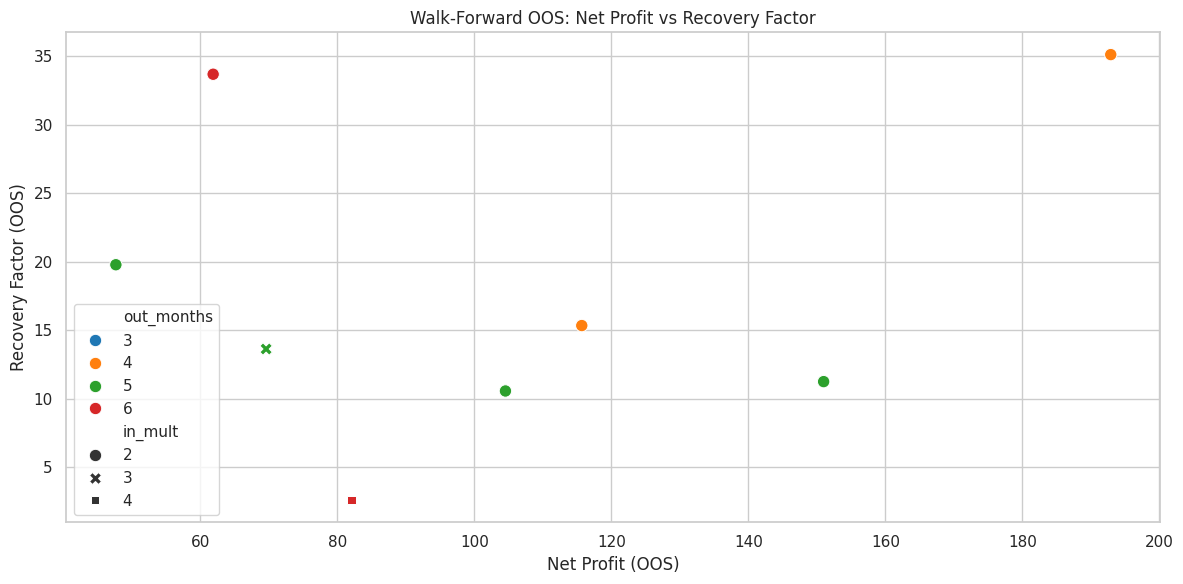

In [18]:
# 8) Scatter OOS: Net vs RF
plt.figure(figsize=(12, 6))
sns.scatterplot(
    data=res_df,
    x="net_oos", y="rf_oos",
    hue="out_months", style="in_mult",
    palette="tab10", s=80
)
plt.title("Walk-Forward OOS: Net Profit vs Recovery Factor")
plt.xlabel("Net Profit (OOS)")
plt.ylabel("Recovery Factor (OOS)")
plt.tight_layout()
plt.show()

In [19]:
# 9) Estatísticas resumidas
summary = (
    res_df
    .groupby(["out_months","in_mult"])
    [["net_oos","rf_oos"]]
    .mean()
    .round(2)
    .reset_index()
)
print("\n=== Summary by IS/OOS Configuration ===")
print(summary)


=== Summary by IS/OOS Configuration ===
    out_months  in_mult  net_oos  rf_oos
0            3        2    50.28     NaN
1            3        3     0.00     NaN
2            3        4     0.00     NaN
3            4        2    58.36   25.22
4            4        3    36.98     NaN
5            4        4    36.91     NaN
6            5        2    60.63   13.85
7            5        3    72.54   13.62
8            5        4     0.00     NaN
9            6        2    46.27   33.68
10           6        3    45.09     NaN
11           6        4    41.04    2.60


/tmp/ipython-input-13-3829972336.py:36: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pnl[i] = ret


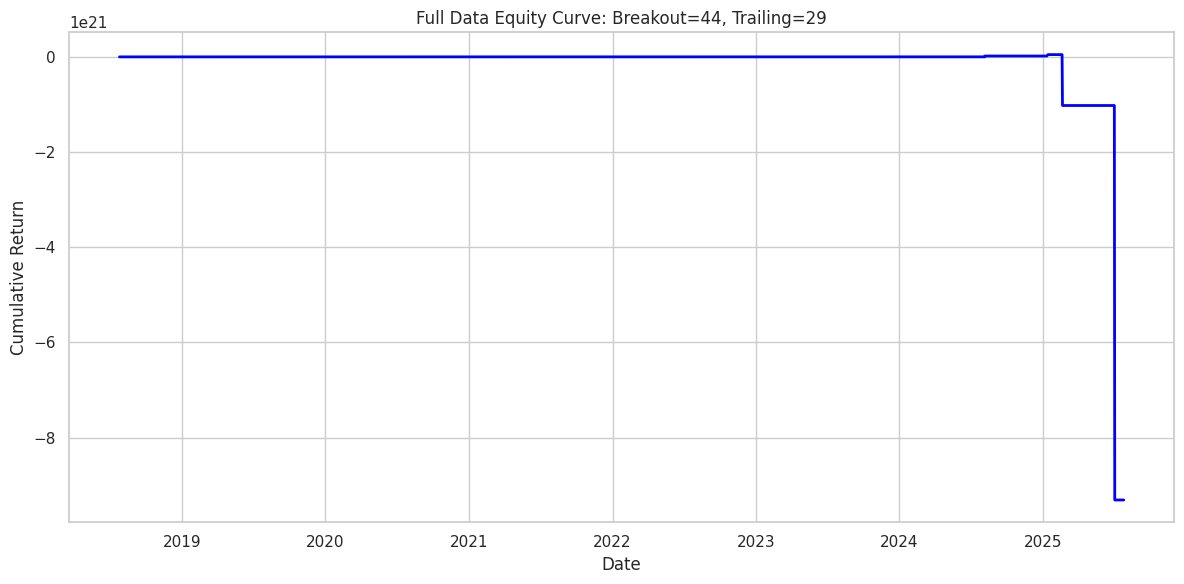

In [20]:
# 10) Gráfico final do melhor parâmetro global
pnl_full = simulate_channel(data, best_bp, best_tp)
cum_ret_full = (1 + pnl_full).cumprod() - 1

plt.figure(figsize=(12, 6))
plt.plot(cum_ret_full.index, cum_ret_full.values, lw=2, color="blue")
plt.title(f"Full Data Equity Curve: Breakout={best_bp}, Trailing={best_tp}")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.grid(True)
plt.tight_layout()
plt.show()